In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import pybiomart
import scvi
import torch
import random
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def SampleQC(adata,
             min_genes=200,
             filter_by_percent_cells=True, percent_cells_threshold=0.1,
             filter_by_percent_mt=True, percent_mt_threshold=10):
    
    n_cells = str(adata.shape[0])
    n_genes = str(adata.shape[1])
    print('Before QC: ' + n_cells + ' cells, ' + n_genes + ' genes')
    
    sc.pp.filter_cells(adata, min_genes=min_genes)
    if filter_by_percent_cells:
        sc.pp.filter_genes(adata, min_cells=round(percent_cells_threshold*adata.shape[0]/100,0))
        
    adata.layers['counts'] = scipy.sparse.csr_matrix(adata.X.copy())
    #adata.layers['log2_counts'] = scipy.sparse.csr_matrix(sc.pp.log1p(adata.layers['counts'],copy(), base=2))
    
    if filter_by_percent_mt:
        adata.var['mt'] = adata.var_names.str.startswith('MT-')
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        adata.obs.rename(columns={'pct_counts_mt':'percent_mt'}, inplace=True)
        adata.var.drop('mt', axis=1, inplace=True)
        adata = adata[adata.obs['percent_mt']<percent_mt_threshold,].copy()
    
    n_cells = str(adata.shape[0])
    n_genes = str(adata.shape[1])
    print('After QC: ' + n_cells + ' cells, ' + n_genes + ' genes')
    
    return adata

In [3]:
cwd = os.getcwd()
cwd

'/Users/deanlee/GitHub/FigureOneLab/example_projects/human_microglia_brain_organoids'

In [4]:
meta_patient = pd.read_csv(cwd+'/data/kracht/aba5906_tables_s1_s10/Table S1-Table 1.csv', sep=',', header=1)
meta_patient.rename(columns={'ID':'PatientID', 'Single cell':'scRNA'}, inplace=True)
meta_patient[['GestationalAge1', 'GestationalAge2']] = meta_patient['Gestational age (weeks + days)'].str.split('+', expand=True)
meta_patient['GestationalAgeDay'] = 7*meta_patient['GestationalAge1'].astype(int) + meta_patient['GestationalAge2'].astype(int)
meta_patient.drop(columns=['Gestational age (weeks + days)', 'Gestational week', 'GestationalAge1', 'GestationalAge2', 'ATAC', 'scRNA'], inplace=True)
meta_patient

,PatientID,Sex,GestationalAgeDay
0,2018-05,F,90
1,2018-09,M,65
2,2018-18,F,91
3,2018-19,M,105
4,2018-20,F,126
5,2018-22,M,86
6,2018-23,M,86
7,2018-25,F,64
8,2018-26,M,80
9,2018-28,F,75


In [5]:
meta_sample = pd.read_csv(cwd+'/data/kracht/SraRunTable.txt', sep=',', header=0)
meta_sample = meta_sample[['donor/fetus','Sample Name']]
meta_sample.rename(columns={'donor/fetus':'PatientID', 'Sample Name':'SampleID'}, inplace=True)
meta_sample

,PatientID,SampleID
0,2018-32,GSM4214849
1,2018-33,GSM4214850
2,2018-34,GSM4214851
3,2018-36,GSM4214852
4,2018-37,GSM4214853
...,...,...
242,2018-41,GSM4215091
243,2018-42,GSM4215092
244,2018-44,GSM4215093
245,2018-05,GSM4215094


In [6]:
meta = pd.merge(meta_sample, meta_patient, on='PatientID', how='left')
meta

,PatientID,SampleID,Sex,GestationalAgeDay
0,2018-32,GSM4214849,F,67
1,2018-33,GSM4214850,F,76
2,2018-34,GSM4214851,F,112
3,2018-36,GSM4214852,M,80
4,2018-37,GSM4214853,F,105
...,...,...,...,...
242,2018-41,GSM4215091,F,80
243,2018-42,GSM4215092,F,105
244,2018-44,GSM4215093,M,119
245,2018-05,GSM4215094,F,90


In [7]:
filenames = [x for x in os.listdir('data/kracht/GSE141862_RAW') if 'completeCounts' in x]

In [8]:
a = sc.queries.biomart_annotations('hsapiens', ['ensembl_gene_id','hgnc_symbol'])
ensembl_hgnc_dict = dict(zip(a['ensembl_gene_id'], a['hgnc_symbol']))

In [9]:
# GSM4214857 to GSM4215095, 239 files

adata_dict = {}

for i in range(4857, 5096):
    
    filename = [x for x in filenames if str(i) in x][0]
    print(filename)
    
    counts = pd.read_csv(cwd+'/data/kracht/GSE141862_RAW/'+filename, compression='gzip', sep='\t', header=0)    
    counts = counts.transpose()
    counts.columns = counts.iloc[0,:]
    counts = counts.iloc[1:,:]
    counts.columns.name = None
    counts = counts.astype(int)
    
    genes = pd.DataFrame(counts.columns)
    genes.rename(columns={0:'EnsemblID'}, inplace=True)
    genes['Genes'] = genes['EnsemblID'].map(ensembl_hgnc_dict)
    genes = genes[~genes['Genes'].isna()]
    genes.index = genes['Genes']
    genes.index.name = None
    
    counts = counts.loc[:, counts.columns.isin(genes['EnsemblID'])]
    
    barcodes = pd.DataFrame(counts.index)
    counts = scipy.sparse.csr_matrix(counts)
    adata = anndata.AnnData(X=counts, obs=barcodes, var=genes)
    adata.var_names_make_unique()

    adata.obs['SampleID'] = filename[0:10]
    adata.obs['PatientID'] = adata.obs['SampleID'].map(dict(zip(meta['SampleID'], meta['PatientID'])))
    adata.obs.rename(columns={0:'CellID'}, inplace=True)
    adata.obs['PatientID_SampleID'] = adata.obs['PatientID'].astype(str) + '_' + adata.obs['SampleID'].astype(str)
    adata.obs['SampleID_CellID'] = adata.obs['SampleID'].astype(str) + '_' + adata.obs['CellID'].astype(str)
    
    # check if barcodes are unique
    patient_sample = adata.obs['PatientID_SampleID'].unique()[0]
    print(patient_sample)
    if adata.obs_names.nunique()!=adata.shape[0]:
        print('Barcodes are not unique.')
    
    adata_dict[patient_sample] = adata

GSM4214857_103591-001-000-001_S1_completeCounts.txt.gz
2018-05_GSM4214857
GSM4214858_103591-001-000-002_S2_completeCounts.txt.gz
2018-05_GSM4214858
GSM4214859_103591-001-000-003_S3_completeCounts.txt.gz
2018-05_GSM4214859
GSM4214860_103591-001-000-004_S4_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-05_GSM4214860
GSM4214861_103591-001-000-005_S5_completeCounts.txt.gz
2018-05_GSM4214861
GSM4214862_103591-001-000-006_S6_completeCounts.txt.gz
2018-05_GSM4214862
GSM4214863_103591-001-000-007_S7_completeCounts.txt.gz
2018-05_GSM4214863
GSM4214864_103591-001-000-008_S8_completeCounts.txt.gz
2018-05_GSM4214864
GSM4214865_103591-001-000-009_S9_completeCounts.txt.gz
2018-05_GSM4214865
GSM4214866_103591-001-000-010_S10_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framew

2018-05_GSM4214866
GSM4214867_103591-001-000-011_S11_completeCounts.txt.gz
2018-05_GSM4214867
GSM4214868_103591-001-000-012_S12_completeCounts.txt.gz
2018-05_GSM4214868
GSM4214869_103591-001-001-001_S1_completeCounts.txt.gz
2018-18_GSM4214869
GSM4214870_103591-001-001-002_S2_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-31_GSM4214870
GSM4214871_103591-001-001-003_S3_completeCounts.txt.gz
2018-32_GSM4214871
GSM4214872_103591-001-001-004_S4_completeCounts.txt.gz
2018-34_GSM4214872
GSM4214873_103591-001-001-005_S5_completeCounts.txt.gz
2018-36_GSM4214873
GSM4214874_103591-001-001-006_S6_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-37_GSM4214874
GSM4214875_103591-001-001-007_S7_completeCounts.txt.gz
2018-41_GSM4214875
GSM4214876_103591-001-001-008_S8_completeCounts.txt.gz
2018-42_GSM4214876
GSM4214877_103591-001-001-009_S9_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-44_GSM4214877
GSM4214878_103591-001-001-010_S10_completeCounts.txt.gz
2018-05_GSM4214878
GSM4214879_103591-001-002-001_S1_completeCounts.txt.gz
2018-18_GSM4214879
GSM4214880_103591-001-002-002_S2_completeCounts.txt.gz
2018-19_GSM4214880
GSM4214881_103591-001-002-003_S3_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-32_GSM4214881
GSM4214882_103591-001-002-004_S4_completeCounts.txt.gz
2018-34_GSM4214882
GSM4214883_103591-001-002-005_S5_completeCounts.txt.gz
2018-36_GSM4214883
GSM4214884_103591-001-002-006_S6_completeCounts.txt.gz
2018-37_GSM4214884
GSM4214885_103591-001-002-007_S7_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-41_GSM4214885
GSM4214886_103591-001-002-008_S8_completeCounts.txt.gz
2018-42_GSM4214886
GSM4214887_103591-001-002-009_S9_completeCounts.txt.gz
2018-44_GSM4214887
GSM4214888_103591-001-002-010_S10_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-09_GSM4214888
GSM4214889_103591-001-003-001_S1_completeCounts.txt.gz
2018-18_GSM4214889
GSM4214890_103591-001-003-002_S2_completeCounts.txt.gz
2018-19_GSM4214890
GSM4214891_103591-001-003-003_S3_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-20_GSM4214891
GSM4214892_103591-001-003-004_S4_completeCounts.txt.gz
2018-34_GSM4214892
GSM4214893_103591-001-003-005_S5_completeCounts.txt.gz
2018-36_GSM4214893
GSM4214894_103591-001-003-006_S6_completeCounts.txt.gz
2018-37_GSM4214894
GSM4214895_103591-001-003-007_S7_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-41_GSM4214895
GSM4214896_103591-001-003-008_S8_completeCounts.txt.gz
2018-42_GSM4214896
GSM4214897_103591-001-003-009_S9_completeCounts.txt.gz
2018-44_GSM4214897
GSM4214898_103591-001-003-010_S10_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-09_GSM4214898
GSM4214899_103591-001-004-001_S1_completeCounts.txt.gz
2018-18_GSM4214899
GSM4214900_103591-001-004-002_S2_completeCounts.txt.gz
2018-19_GSM4214900
GSM4214901_103591-001-004-003_S3_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-20_GSM4214901
GSM4214902_103591-001-004-004_S4_completeCounts.txt.gz
2018-22_GSM4214902
GSM4214903_103591-001-004-005_S5_completeCounts.txt.gz
2018-36_GSM4214903
GSM4214904_103591-001-004-006_S6_completeCounts.txt.gz
2018-37_GSM4214904
GSM4214905_103591-001-004-007_S7_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-41_GSM4214905
GSM4214906_103591-001-004-008_S8_completeCounts.txt.gz
2018-42_GSM4214906
GSM4214907_103591-001-004-009_S9_completeCounts.txt.gz
2018-44_GSM4214907
GSM4214908_103591-001-004-010_S10_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-09_GSM4214908
GSM4214909_103591-001-005-001_S1_completeCounts.txt.gz
2018-18_GSM4214909
GSM4214910_103591-001-005-002_S2_completeCounts.txt.gz
2018-19_GSM4214910
GSM4214911_103591-001-005-003_S3_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-20_GSM4214911
GSM4214912_103591-001-005-004_S4_completeCounts.txt.gz
2018-22_GSM4214912
GSM4214913_103591-001-005-005_S5_completeCounts.txt.gz
2018-23_GSM4214913
GSM4214914_103591-001-005-006_S6_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-37_GSM4214914
GSM4214915_103591-001-005-007_S7_completeCounts.txt.gz
2018-41_GSM4214915
GSM4214916_103591-001-005-008_S8_completeCounts.txt.gz
2018-42_GSM4214916
GSM4214917_103591-001-005-009_S9_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-44_GSM4214917
GSM4214918_103591-001-005-010_S10_completeCounts.txt.gz
2018-09_GSM4214918
GSM4214919_103591-001-006-001_S1_completeCounts.txt.gz
2018-18_GSM4214919
GSM4214920_103591-001-006-002_S2_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-09_GSM4214920
GSM4214921_103591-001-006-003_S3_completeCounts.txt.gz
2018-20_GSM4214921
GSM4214922_103591-001-006-004_S4_completeCounts.txt.gz
2018-22_GSM4214922
GSM4214923_103591-001-006-005_S5_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-23_GSM4214923
GSM4214924_103591-001-006-006_S6_completeCounts.txt.gz
2018-25_GSM4214924
GSM4214925_103591-001-006-007_S7_completeCounts.txt.gz
2018-41_GSM4214925
GSM4214926_103591-001-006-008_S8_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-42_GSM4214926
GSM4214927_103591-001-006-009_S9_completeCounts.txt.gz
2018-44_GSM4214927
GSM4214928_103591-001-006-010_S10_completeCounts.txt.gz
2018-09_GSM4214928
GSM4214929_103591-001-007-001_S1_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-18_GSM4214929
GSM4214930_103591-001-007-002_S2_completeCounts.txt.gz
2018-09_GSM4214930
GSM4214931_103591-001-007-003_S3_completeCounts.txt.gz
2018-20_GSM4214931
GSM4214932_103591-001-007-004_S4_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-22_GSM4214932
GSM4214933_103591-001-007-005_S5_completeCounts.txt.gz
2018-23_GSM4214933
GSM4214934_103591-001-007-006_S6_completeCounts.txt.gz
2018-25_GSM4214934
GSM4214935_103591-001-007-007_S7_completeCounts.txt.gz
2018-26_GSM4214935
GSM4214936_103591-001-007-008_S8_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-42_GSM4214936
GSM4214937_103591-001-007-009_S9_completeCounts.txt.gz
2018-44_GSM4214937
GSM4214938_103591-001-007-010_S10_completeCounts.txt.gz
2018-09_GSM4214938
GSM4214939_103591-001-008-001_S1_completeCounts.txt.gz
2018-18_GSM4214939
GSM4214940_103591-001-008-002_S2_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-09_GSM4214940
GSM4214941_103591-001-008-003_S3_completeCounts.txt.gz
2018-20_GSM4214941
GSM4214942_103591-001-008-004_S4_completeCounts.txt.gz
2018-22_GSM4214942
GSM4214943_103591-001-008-005_S5_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-23_GSM4214943
GSM4214944_103591-001-008-006_S6_completeCounts.txt.gz
2018-25_GSM4214944
GSM4214945_103591-001-008-007_S7_completeCounts.txt.gz
2018-26_GSM4214945
GSM4214946_103591-001-008-008_S8_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-28_GSM4214946
GSM4214947_103591-001-008-009_S9_completeCounts.txt.gz
2018-44_GSM4214947
GSM4214948_103591-001-008-010_S10_completeCounts.txt.gz
2018-09_GSM4214948
GSM4214949_103591-001-009-001_S1_completeCounts.txt.gz
2018-18_GSM4214949
GSM4214950_103591-001-009-002_S2_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-09_GSM4214950
GSM4214951_103591-001-009-003_S3_completeCounts.txt.gz
2018-20_GSM4214951
GSM4214952_103591-001-009-004_S4_completeCounts.txt.gz
2018-22_GSM4214952
GSM4214953_103591-001-009-005_S5_completeCounts.txt.gz
2018-23_GSM4214953
GSM4214954_103591-001-009-006_S6_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-25_GSM4214954
GSM4214955_103591-001-009-007_S7_completeCounts.txt.gz
2018-26_GSM4214955
GSM4214956_103591-001-009-008_S8_completeCounts.txt.gz
2018-28_GSM4214956
GSM4214957_103591-001-009-009_S9_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-29_GSM4214957
GSM4214958_103591-001-009-010_S10_completeCounts.txt.gz
2018-09_GSM4214958
GSM4214959_103591-001-010-001_S1_completeCounts.txt.gz
2018-18_GSM4214959
GSM4214960_103591-001-010-002_S2_completeCounts.txt.gz
2018-19_GSM4214960
GSM4214961_103591-001-010-003_S3_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-20_GSM4214961
GSM4214962_103591-001-010-004_S4_completeCounts.txt.gz
2018-22_GSM4214962
GSM4214963_103591-001-010-005_S5_completeCounts.txt.gz
2018-23_GSM4214963
GSM4214964_103591-001-010-006_S6_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-25_GSM4214964
GSM4214965_103591-001-010-007_S7_completeCounts.txt.gz
2018-26_GSM4214965
GSM4214966_103591-001-010-008_S8_completeCounts.txt.gz
2018-28_GSM4214966
GSM4214967_103591-001-010-009_S9_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-29_GSM4214967
GSM4214968_103591-001-010-010_S10_completeCounts.txt.gz
2018-30_GSM4214968
GSM4214969_103591-001-011-001_S1_completeCounts.txt.gz
2018-18_GSM4214969
GSM4214970_103591-001-011-002_S2_completeCounts.txt.gz
2018-19_GSM4214970
GSM4214971_103591-001-011-003_S3_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-20_GSM4214971
GSM4214972_103591-001-011-004_S4_completeCounts.txt.gz
2018-22_GSM4214972
GSM4214973_103591-001-011-005_S5_completeCounts.txt.gz
2018-23_GSM4214973
GSM4214974_103591-001-011-006_S6_completeCounts.txt.gz
2018-25_GSM4214974
GSM4214975_103591-001-011-007_S7_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-26_GSM4214975
GSM4214976_103591-001-011-008_S8_completeCounts.txt.gz
2018-28_GSM4214976
GSM4214977_103591-001-011-009_S9_completeCounts.txt.gz
2018-29_GSM4214977
GSM4214978_103591-001-011-010_S10_completeCounts.txt.gz
2018-30_GSM4214978
GSM4214979_103591-001-012-001_S1_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-18_GSM4214979
GSM4214980_103591-001-012-002_S2_completeCounts.txt.gz
2018-19_GSM4214980
GSM4214981_103591-001-012-003_S3_completeCounts.txt.gz
2018-20_GSM4214981
GSM4214982_103591-001-012-004_S4_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-22_GSM4214982
GSM4214983_103591-001-012-005_S5_completeCounts.txt.gz
2018-23_GSM4214983
GSM4214984_103591-001-012-006_S6_completeCounts.txt.gz
2018-25_GSM4214984
GSM4214985_103591-001-012-007_S7_completeCounts.txt.gz
2018-26_GSM4214985
GSM4214986_103591-001-012-008_S8_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-28_GSM4214986
GSM4214987_103591-001-012-009_S9_completeCounts.txt.gz
2018-29_GSM4214987
GSM4214988_103591-001-012-010_S10_completeCounts.txt.gz
2018-30_GSM4214988
GSM4214989_103591-001-013-001_S1_completeCounts.txt.gz
2018-31_GSM4214989
GSM4214990_103591-001-013-002_S2_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-19_GSM4214990
GSM4214991_103591-001-013-003_S3_completeCounts.txt.gz
2018-20_GSM4214991
GSM4214992_103591-001-013-004_S4_completeCounts.txt.gz
2018-22_GSM4214992
GSM4214993_103591-001-013-005_S5_completeCounts.txt.gz
2018-23_GSM4214993
GSM4214994_103591-001-013-006_S6_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-25_GSM4214994
GSM4214995_103591-001-013-007_S7_completeCounts.txt.gz
2018-26_GSM4214995
GSM4214996_103591-001-013-008_S8_completeCounts.txt.gz
2018-28_GSM4214996
GSM4214997_103591-001-013-009_S9_completeCounts.txt.gz
2018-09_GSM4214997
GSM4214998_103591-001-013-010_S10_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-30_GSM4214998
GSM4214999_103591-001-014-001_S1_completeCounts.txt.gz
2018-31_GSM4214999
GSM4215000_103591-001-014-002_S2_completeCounts.txt.gz
2018-32_GSM4215000
GSM4215001_103591-001-014-003_S3_completeCounts.txt.gz
2018-20_GSM4215001
GSM4215002_103591-001-014-004_S4_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-22_GSM4215002
GSM4215003_103591-001-014-005_S5_completeCounts.txt.gz
2018-23_GSM4215003
GSM4215004_103591-001-014-006_S6_completeCounts.txt.gz
2018-25_GSM4215004
GSM4215005_103591-001-014-007_S7_completeCounts.txt.gz
2018-26_GSM4215005
GSM4215006_103591-001-014-008_S8_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-28_GSM4215006
GSM4215007_103591-001-014-009_S9_completeCounts.txt.gz
2018-09_GSM4215007
GSM4215008_103591-001-014-010_S10_completeCounts.txt.gz
2018-30_GSM4215008
GSM4215009_103591-001-015-001_S1_completeCounts.txt.gz
2018-31_GSM4215009
GSM4215010_103591-001-015-002_S2_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-32_GSM4215010
GSM4215011_103591-001-015-003_S3_completeCounts.txt.gz
2018-34_GSM4215011
GSM4215012_103591-001-015-004_S4_completeCounts.txt.gz
2018-22_GSM4215012
GSM4215013_103591-001-015-005_S5_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-23_GSM4215013
GSM4215014_103591-001-015-006_S6_completeCounts.txt.gz
2018-25_GSM4215014
GSM4215015_103591-001-015-007_S7_completeCounts.txt.gz
2018-26_GSM4215015
GSM4215016_103591-001-015-008_S8_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-28_GSM4215016
GSM4215017_103591-001-015-009_S9_completeCounts.txt.gz
2018-29_GSM4215017
GSM4215018_103591-001-015-010_S10_completeCounts.txt.gz
2018-30_GSM4215018
GSM4215019_103591-001-016-001_S1_completeCounts.txt.gz
2018-31_GSM4215019
GSM4215020_103591-001-016-002_S2_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-32_GSM4215020
GSM4215021_103591-001-016-003_S3_completeCounts.txt.gz
2018-34_GSM4215021
GSM4215022_103591-001-016-004_S4_completeCounts.txt.gz
2018-36_GSM4215022
GSM4215023_103591-001-016-005_S5_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-23_GSM4215023
GSM4215024_103591-001-016-006_S7_completeCounts.txt.gz
2018-25_GSM4215024
GSM4215025_103591-001-016-007_S6_completeCounts.txt.gz
2018-26_GSM4215025
GSM4215026_103591-001-016-008_S8_completeCounts.txt.gz
2018-28_GSM4215026
GSM4215027_103591-001-016-009_S9_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-29_GSM4215027
GSM4215028_103591-001-016-010_S10_completeCounts.txt.gz
2018-30_GSM4215028
GSM4215029_103591-001-017-001_S1_completeCounts.txt.gz
2018-31_GSM4215029
GSM4215030_103591-001-017-002_S2_completeCounts.txt.gz
2018-32_GSM4215030
GSM4215031_103591-001-017-003_S3_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-34_GSM4215031
GSM4215032_103591-001-017-004_S4_completeCounts.txt.gz
2018-36_GSM4215032
GSM4215033_103591-001-017-005_S5_completeCounts.txt.gz
2018-37_GSM4215033
GSM4215034_103591-001-017-006_S6_completeCounts.txt.gz
2018-26_GSM4215034
GSM4215035_103591-001-017-007_S7_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-05_GSM4215035
GSM4215036_103591-001-017-008_S8_completeCounts.txt.gz
2018-29_GSM4215036
GSM4215037_103591-001-017-009_S9_completeCounts.txt.gz
2018-30_GSM4215037
GSM4215038_103591-001-018-001_S1_completeCounts.txt.gz
2018-31_GSM4215038
GSM4215039_103591-001-018-002_S2_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-32_GSM4215039
GSM4215040_103591-001-018-003_S3_completeCounts.txt.gz
2018-34_GSM4215040
GSM4215041_103591-001-018-004_S4_completeCounts.txt.gz
2018-36_GSM4215041
GSM4215042_103591-001-018-005_S5_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-37_GSM4215042
GSM4215043_103591-001-018-006_S6_completeCounts.txt.gz
2018-41_GSM4215043
GSM4215044_103591-001-018-007_S7_completeCounts.txt.gz
2018-26_GSM4215044
GSM4215045_103591-001-018-008_S8_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-29_GSM4215045
GSM4215046_103591-001-018-009_S9_completeCounts.txt.gz
2018-30_GSM4215046
GSM4215047_103591-001-019-001_S1_completeCounts.txt.gz
2018-31_GSM4215047
GSM4215048_103591-001-019-002_S2_completeCounts.txt.gz
2018-32_GSM4215048
GSM4215049_103591-001-019-003_S3_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-34_GSM4215049
GSM4215050_103591-001-019-004_S4_completeCounts.txt.gz
2018-36_GSM4215050
GSM4215051_103591-001-019-005_S5_completeCounts.txt.gz
2018-37_GSM4215051
GSM4215052_103591-001-019-006_S6_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-41_GSM4215052
GSM4215053_103591-001-019-007_S7_completeCounts.txt.gz
2018-42_GSM4215053
GSM4215054_103591-001-019-008_S8_completeCounts.txt.gz
2018-29_GSM4215054
GSM4215055_103591-001-019-009_S9_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-30_GSM4215055
GSM4215056_103591-001-020-001_S1_completeCounts.txt.gz
2018-31_GSM4215056
GSM4215057_103591-001-020-002_S2_completeCounts.txt.gz
2018-32_GSM4215057
GSM4215058_103591-001-020-003_S3_completeCounts.txt.gz
2018-34_GSM4215058
GSM4215059_103591-001-020-004_S4_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-36_GSM4215059
GSM4215060_103591-001-020-005_S5_completeCounts.txt.gz
2018-37_GSM4215060
GSM4215061_103591-001-020-006_S6_completeCounts.txt.gz
2018-41_GSM4215061
GSM4215062_103591-001-020-007_S7_completeCounts.txt.gz
2018-42_GSM4215062
GSM4215063_103591-001-020-008_S8_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-44_GSM4215063
GSM4215064_103591-001-020-009_S9_completeCounts.txt.gz
2018-29_GSM4215064
GSM4215065_103591-001-020-010_S10_completeCounts.txt.gz
2018-30_GSM4215065
GSM4215066_103591-001-021-001_S1_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-31_GSM4215066
GSM4215067_103591-001-021-002_S2_completeCounts.txt.gz
2018-32_GSM4215067
GSM4215068_103591-001-021-003_S3_completeCounts.txt.gz
2018-34_GSM4215068
GSM4215069_103591-001-021-004_S4_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-36_GSM4215069
GSM4215070_103591-001-021-005_S5_completeCounts.txt.gz
2018-37_GSM4215070
GSM4215071_103591-001-021-006_S6_completeCounts.txt.gz
2018-41_GSM4215071
GSM4215072_103591-001-021-007_S7_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-42_GSM4215072
GSM4215073_103591-001-021-008_S8_completeCounts.txt.gz
2018-44_GSM4215073
GSM4215074_103591-001-021-009_S9_completeCounts.txt.gz
2018-05_GSM4215074
GSM4215075_103591-001-021-010_S10_completeCounts.txt.gz
2018-30_GSM4215075
GSM4215076_103591-001-022-001_S1_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-31_GSM4215076
GSM4215077_103591-001-022-002_S2_completeCounts.txt.gz
2018-32_GSM4215077
GSM4215078_103591-001-022-003_S3_completeCounts.txt.gz
2018-34_GSM4215078
GSM4215079_103591-001-022-004_S4_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-36_GSM4215079
GSM4215080_103591-001-022-005_S5_completeCounts.txt.gz
2018-37_GSM4215080
GSM4215081_103591-001-022-006_S6_completeCounts.txt.gz
2018-41_GSM4215081
GSM4215082_103591-001-022-007_S7_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-42_GSM4215082
GSM4215083_103591-001-022-008_S8_completeCounts.txt.gz
2018-44_GSM4215083
GSM4215084_103591-001-022-009_S9_completeCounts.txt.gz
2018-05_GSM4215084
GSM4215085_103591-001-022-010_S10_completeCounts.txt.gz
2018-09_GSM4215085
GSM4215086_103591-001-023-001_S1_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-31_GSM4215086
GSM4215087_103591-001-023-002_S2_completeCounts.txt.gz
2018-32_GSM4215087
GSM4215088_103591-001-023-003_S3_completeCounts.txt.gz
2018-34_GSM4215088
GSM4215089_103591-001-023-004_S4_completeCounts.txt.gz


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

2018-36_GSM4215089
GSM4215090_103591-001-023-005_S5_completeCounts.txt.gz
2018-37_GSM4215090
GSM4215091_103591-001-023-006_S6_completeCounts.txt.gz
2018-41_GSM4215091
GSM4215092_103591-001-023-007_S7_completeCounts.txt.gz
2018-42_GSM4215092
GSM4215093_103591-001-023-008_S8_completeCounts.txt.gz
2018-44_GSM4215093
GSM4215094_103591-001-023-009_S9_completeCounts.txt.gz
2018-05_GSM4215094
GSM4215095_103591-001-023-010_S10_completeCounts.txt.gz
2018-09_GSM4215095


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.fra

In [10]:
adata_dict

{'2018-05_GSM4214857': AnnData object with n_obs × n_vars = 58 × 9675
     obs: 'CellID', 'SampleID', 'PatientID', 'PatientID_SampleID', 'SampleID_CellID'
     var: 'EnsemblID', 'Genes',
 '2018-05_GSM4214858': AnnData object with n_obs × n_vars = 59 × 11147
     obs: 'CellID', 'SampleID', 'PatientID', 'PatientID_SampleID', 'SampleID_CellID'
     var: 'EnsemblID', 'Genes',
 '2018-05_GSM4214859': AnnData object with n_obs × n_vars = 65 × 11457
     obs: 'CellID', 'SampleID', 'PatientID', 'PatientID_SampleID', 'SampleID_CellID'
     var: 'EnsemblID', 'Genes',
 '2018-05_GSM4214860': AnnData object with n_obs × n_vars = 58 × 10141
     obs: 'CellID', 'SampleID', 'PatientID', 'PatientID_SampleID', 'SampleID_CellID'
     var: 'EnsemblID', 'Genes',
 '2018-05_GSM4214861': AnnData object with n_obs × n_vars = 47 × 5348
     obs: 'CellID', 'SampleID', 'PatientID', 'PatientID_SampleID', 'SampleID_CellID'
     var: 'EnsemblID', 'Genes',
 '2018-05_GSM4214862': AnnData object with n_obs × n_vars = 60

In [11]:
adata = anndata.concat(adata_dict.values(), join='outer')
adata.obs_names_make_unique()
adata

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17295 × 32451
    obs: 'CellID', 'SampleID', 'PatientID', 'PatientID_SampleID', 'SampleID_CellID'

In [12]:
adata = SampleQC(adata,
                 min_genes=200,
                 filter_by_percent_cells=True, percent_cells_threshold=0.1,
                 filter_by_percent_mt=True, percent_mt_threshold=10)
adata

Before QC: 17295 cells, 32451 genes
After QC: 16613 cells, 20327 genes


AnnData object with n_obs × n_vars = 16613 × 20327
    obs: 'CellID', 'SampleID', 'PatientID', 'PatientID_SampleID', 'SampleID_CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'percent_mt'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

In [13]:
%%time
random.seed(17)
scvi.model.SCVI.setup_anndata(adata, layer='counts', batch_key='SampleID')
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, n_hidden=128, gene_likelihood='nb')
scvi_model.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/400:   0%|                                      | 0/400 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 400/400: 100%|█| 400/400 [6:14:30<00:00, 38.34s/it, v_num=1, train_loss_st

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [6:14:30<00:00, 56.18s/it, v_num=1, train_loss_st
CPU times: user 4h 59min 15s, sys: 50min 58s, total: 5h 50min 14s
Wall time: 6h 14min 31s


In [14]:
%%time
random.seed(17)
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()
adata.layers['counts_scvi'] = scvi_model.get_normalized_expression(library_size=10000)
#adata.layers['log2_counts_scvi'] = sc.pp.log1p(adata.layers['counts_scvi'].copy(), base=2)

CPU times: user 7.32 s, sys: 3.39 s, total: 10.7 s
Wall time: 5.95 s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


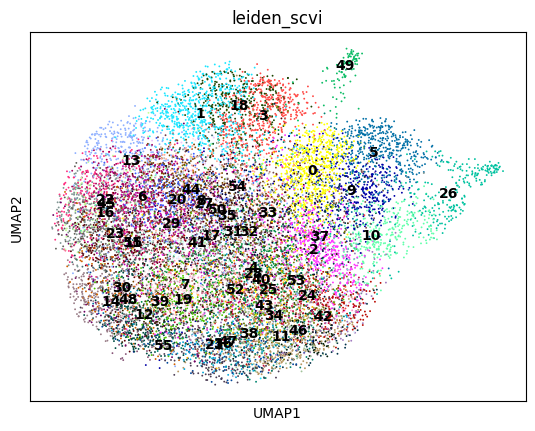

CPU times: user 54 s, sys: 827 ms, total: 54.8 s
Wall time: 50 s


In [15]:
%%time
random.seed(17)
sc.pp.neighbors(adata, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=20)
sc.tl.leiden(adata, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=3)
sc.tl.umap(adata, neighbors_key='neighbors_scvi')
sc.pl.umap(adata, color=['leiden_scvi'], legend_loc='on data')

In [16]:
adata.obs = pd.merge(adata.obs, meta_patient, on='PatientID', how='left')

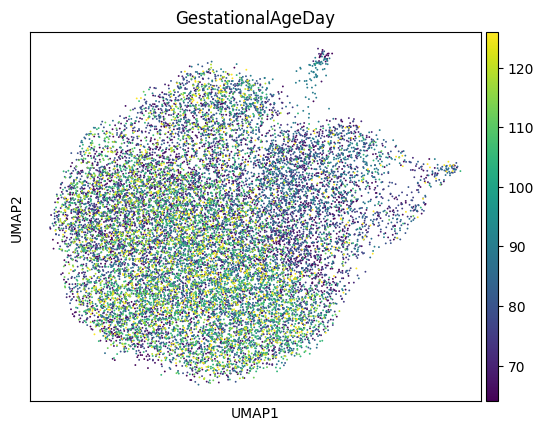

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


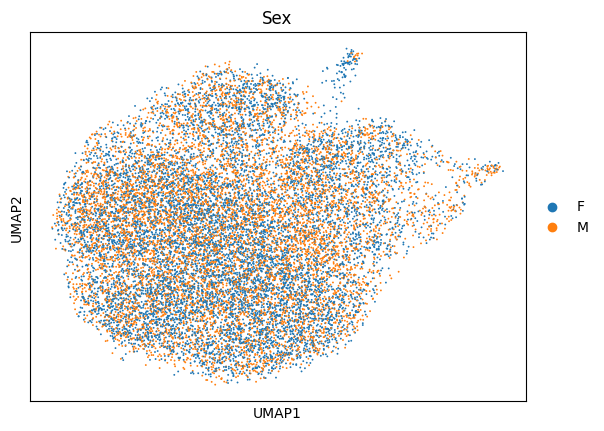

In [17]:
sc.pl.umap(adata, color=['GestationalAgeDay'])
sc.pl.umap(adata, color=['Sex'])

In [18]:
%%time
adata.write(cwd+'/outs/240201_kracht_scvi.h5ad')
scvi_model.save(cwd+'/outs/240201_kracht_scvi_model/', overwrite=True)

CPU times: user 457 ms, sys: 1.49 s, total: 1.94 s
Wall time: 22.1 s
